Monte-Carlo Simulation
: Repeat the following procedures for supervised, un-
supervised, and semi-supervised learning
M
= 30 times, and use randomly selected train and test data (make sure you use 20% of both the positve and negative classes as the test set). Then compare the
average
scores (accuracy, precision,
recall,
F
1
-score, and AUC) that you obtain from each algorithm.

In [2]:
import numpy as np
import pandas as pd
import statistics
import joblib
import os
import warnings
from sklearn import preprocessing
from sklearn import svm, metrics
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans, SpectralClustering 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc, roc_curve, classification_report, roc_auc_score, accuracy_score
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler, normalize 
from statistics import mean

In [38]:
#Import data
filename = "../data/wdbc.data"
df = pd.read_csv(filename, delimiter=",")
df.columns = ["id","diagnosis","radius_mean","texture_mean","perimeter_mean",
       "area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean",
       "symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se",
       "smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se",
       "fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst",
       "smoothness_worst","compactness_worst","concavity_worst","concave points_worst",
       "symmetry_worst","fractal_dimension_worst"]

#Check for missing values
# df.isnull().sum()
# df.isna().sum()
# df.info()
#confirmed that the data has no missing values

#Assigning X and Y:
X = df.iloc[:,2:]
Y = df.iloc[:,1:2]
# print (X.shape,Y.shape)

#Encode Variables
Y = Y["diagnosis"].astype('category').cat.codes
# M == 1; B == 0


#-------------------------------------Found a better way instead of this -- 'stratify'ㄱ--------------------------------------
#Split test & training data -- "make sure to use 20% of both positive & negative classes as the test set"
#Find out minimum number of positive & negative classes should contain in order to make sure 20% of each classes are used.
#     Xp = np.where(Y == 0)[0]
#     Yp = Y[Xp]
#     Ypos = pd.DataFrame(Yp,columns = ['Benign'])
#     Xn = np.where(Y == 1)[0]
#     Yn = Y[Xn]
#     Yneg = pd.DataFrame(Yn,columns = ['Malignant'])
#     YposTrain,YposTest  = train_test_split(Ypos,test_size = 0.2)
#     YnegTrain, YnegTest = train_test_split(Yneg,test_size = 0.2)
#For Positive class: 72 and for negative class: 43

#Split test & training data -- 
#     while True:
#         X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30)
#         B_test = np.where(Y_test == 0)[0]
#         M_test = np.where(Y_test == 1)[0]
#         if len(B_test) < 72:
#             X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30)
#         elif len(M_test) < 43:
#             X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30)
#         else:
#             break
    
#-----------------------------------------------------------------------------------------------------------------


In [40]:
#Normalize data -- do it before splitting data.

Y_new = Y.values.reshape(-1,1)
scaler = StandardScaler()
scaler.fit(X)
scaler.transform(X)
scaler.fit(Y_new)
scaler.transform(Y_new)
#Split test & training data -- "make sure to use 20% of both positive & negative classes as the test set"
X_train, X_test, Y_train, Y_test = train_test_split(X,Y_new, test_size = 0.20, random_state=None, stratify = Y)


(i)Supervised Learning:
Train an
L
1
-penalized SVM to classify the data.
Use 5 fold cross validation to choose the penalty parameter. Use normalized
data. Report the average accuracy, precision, recall,
F
1
-score, and AUC, for
both training and test sets over your
M
runs. Plot the ROC and report the
confusion matrix for training and testing in one of the runs

In [41]:
#Function to find the penalty parameter
def L1_pen_Random(X,y):
    C_range = np.logspace(-2.3, -1.3, 10)
    param_grid = dict(C=C_range)
    randclf = RandomizedSearchCV(svm.LinearSVC(penalty = 'l1',dual=False, max_iter = 1000000), param_grid, cv = 5)
    randclf.fit(X,y)
    return randclf.best_params_

In [42]:
#Optimal Parameter with L1 Regularization
best_prm = L1_pen_Random(X_train, Y_train.ravel())
print (best_prm)

{'C': 0.05011872336272722}


In [43]:
#Fit L 1 -penalized SVM with the found optimal C
clf = LinearSVC(penalty = 'l1',dual=False, max_iter = 1000000, C = best_prm['C'])
clf.fit(X_train, Y_train.ravel())
Y_pred = clf.predict(X_test)

report = {}
accuracy = clf.score(X_test,Y_test)
report['Accuracy'] = accuracy
cr = precision_recall_fscore_support(Y_test, Y_pred, average='weighted')
report['Classification_R'] = cr
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred)
AUC = metrics.auc(fpr, tpr)
report['AUC'] = AUC
print ("Accuracy: ",report['Accuracy'])
print ("Precision: ", report["Classification_R"][0])
print ("Recall: ", report["Classification_R"][1])
print ("F1-Score: ", report["Classification_R"][2])
print ("AUC: ", report["AUC"])

Accuracy:  0.956140350877193
Precision:  0.9565052493664558
Recall:  0.956140350877193
F1-Score:  0.956244993396696
AUC:  0.9553571428571429


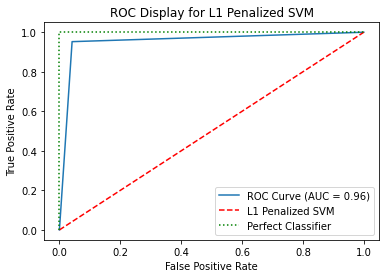

In [44]:
#Plot ROC
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label='ROC Curve (AUC = %0.2f)'%(roc_auc))
plt.plot([0,1],[0,1], linestyle='--',color='red',label = 'L1 Penalized SVM')
plt.plot([0,0,1],[0,1,1],linestyle=':',color = 'green', label='Perfect Classifier')
plt.title('ROC Display for L1 Penalized SVM')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [45]:
cm = confusion_matrix(Y_test, Y_pred)
print ("Confusion Matrix", "\n", cm)


Confusion Matrix 
 [[69  3]
 [ 2 40]]


In [218]:
#Monte-Carlo: 

avg_acc = []
avg_prc = []
avg_rec = []
avg_F = []
avg_AUC = []

#MC = 30
for mc in range (30):
    #Split test & training data -- "make sure to use 20% of both positive & negative classes as the test set"
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y_new, test_size = 0.20, random_state=None, stratify = Y)

    #Optimal Parameter with L1 Regularization
    best_prm = L1_pen_Random(X_train, Y_train.ravel())
    
    #Optimal Parameter with L1 Regularization
    best_prm = L1_pen_Random(X_train, Y_train.ravel())
    clf = LinearSVC(penalty = 'l1',dual=False, max_iter = 1000000, C = best_prm['C'])
    clf.fit(X_train, Y_train.ravel())
    Y_pred = clf.predict(X_test)

    # average accuracy, precision, recall, F 1 -score, and AUC
    report = {}
    accuracy = clf.score(X_test,Y_test)
    report['Accuracy'] = accuracy
    cr = precision_recall_fscore_support(Y_test, Y_pred, average='weighted')
    report['Classification_R'] = cr
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred)
    AUC = metrics.auc(fpr, tpr)
    report['AUC'] = AUC

    avg_acc.append(report['Accuracy'])
    avg_prc.append(report['Classification_R'][0])
    avg_rec.append(report['Classification_R'][1])
    avg_F.append(report['Classification_R'][2])
    avg_AUC.append(report['AUC'])
    
print ("Average Accuracy: ",mean(avg_rec))
print ("Average Precision: ",mean(avg_prc))
print ("Average Recall: ",mean(avg_rec))
print ("Average F1-Score: ",mean(avg_F))
print ("Average AUC: ",mean(avg_AUC))

Average Accuracy:  0.9383040935672514
Average Precision:  0.9389334415212081
Average Recall:  0.9383040935672514
Average F1-Score:  0.9378780666906155
Average AUC:  0.9288359788359789


(ii)Semi-Supervised Learning/ Self-training:
select 50% of the positive
class along with 50% of the negative class in the training set as
labeled data
and the rest as
unlabelled data
. You can select them randomly.

In [219]:
#Split test & training data -- "make sure to use 20% of both positive & negative classes as the test set"
X_train, X_test, Y_train, Y_test = train_test_split(X,Y_new, test_size = 0.20, random_state=None, stratify = Y)


#split test and training data 
iiX_train, iiX_test, iiY_train, iiY_test = train_test_split(X,Y_new, test_size = 0.20, random_state=None, stratify = Y)
#split unlabelled and labelled data 50% 
Xlabelled, Xunlabelled, Ylabelled, Yunlabelled = train_test_split(iiX_train, iiY_train, test_size = 0.5, random_state = None, stratify = Y_train)

# print (Xlabelled.shape,Ylabelled.shape,Xunlabelled.shape,Yunlabelled.shape, iiX_test.shape, iiY_test.shape)

A.
Train an
L
1
-penalized SVM to classify the labeled data Use normalized
data. Choose the penalty parameter using 5 fold cross validation

In [220]:
#Function to find the penalty parameter
def L1_pen_lab(X,y):
    C_range = np.logspace(-2.3, -1.3, 10)
    param_grid = dict(C=C_range)
    randclf = RandomizedSearchCV(svm.LinearSVC(penalty = 'l1',dual=False, max_iter = 100000), param_grid, cv = 5)
    randclf.fit(X,y)
    return randclf.best_params_

In [221]:
#Optimal Parameter with L1 Regularization
ii_best_prm = L1_pen_lab(Xlabelled, Ylabelled.ravel())
print (ii_best_prm)

{'C': 0.01801173528334133}


In [223]:
#Fit L 1 -penalized SVM with the found optimal C
labclf = LinearSVC(penalty = 'l1',dual=False, max_iter = 100000, C = ii_best_prm['C'])
labclf.fit(Xlabelled, Ylabelled.ravel())


LinearSVC(C=0.01801173528334133, dual=False, max_iter=100000, penalty='l1')

Find the unlabeled data point that is the farthest to the decision boundary
of the SVM. Let the SVM label it (ignore its true label), and add it to
the labeled data, and retrain the SVM. Continue this process until all
unlabeled data are used. Test the final SVM on the test data andthe
average accuracy, precision, recall,
F
1
-score, and AUC, for both training
and test sets over your
M
runs. Plot the ROC and report the confusion
matrix for training and testing in one of the runs.

Accuracy:  0.9210526315789473
Precision:  0.8231578947368421
Recall:  0.7543859649122807
F1-Score:  0.7129742962056302
AUC:  0.6666666666666666
Confusion Matrix 
 [[72  0]
 [28 14]]


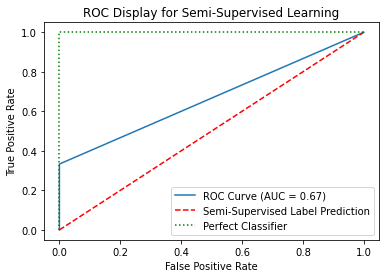

In [224]:
Xunla = Xunlabelled.copy(deep=True)
CI = clf.decision_function(Xunla)
Xunla['CI'] = CI

#Loop that will move the farthest CI to labelled ds

tobemoved = pd.DataFrame()

for i in range(Xunla.shape[0]):
    maxci = Xunla['CI']
    CIMAX = maxci.idxmax()
    row = Xunla.loc[[CIMAX]]
    Xunla= Xunla.drop([CIMAX])
    #pop CI column
    curX = row.iloc[:,:-1]
    
    curY = labclf.predict(curX)
    curY = pd.DataFrame(curY)
    tobemoved = pd.concat([tobemoved,curY])

#concat the labelled unlabelled datapoints with the labels:
Ylabelled = pd.DataFrame(Ylabelled)

finalXtrain = pd.concat([Xlabelled,Xunlabelled])
finalYtrain = pd.concat([Ylabelled,tobemoved], axis = 0)


#Fit L 1 -penalized SVM with the found optimal C
labclf.fit(finalXtrain, finalYtrain.values.ravel())
iiY_pred = labclf.predict(iiX_test)

report = {}
accuracy = clf.score(iiX_test,iiY_test)
report['Accuracy'] = accuracy
cr = precision_recall_fscore_support(iiY_test, iiY_pred, average='weighted')
report['Classification_R'] = cr
fpr, tpr, thresholds = metrics.roc_curve(iiY_test, iiY_pred)
AUC = metrics.auc(fpr, tpr)
report['AUC'] = AUC
print ("Accuracy: ",report['Accuracy'])
print ("Precision: ", report["Classification_R"][0])
print ("Recall: ", report["Classification_R"][1])
print ("F1-Score: ", report["Classification_R"][2])
print ("AUC: ", report["AUC"])

cm = confusion_matrix(iiY_test, iiY_pred)
print ("Confusion Matrix", "\n", cm)

#Plot ROC
fpr, tpr, thresholds = metrics.roc_curve(iiY_test, iiY_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label='ROC Curve (AUC = %0.2f)'%(roc_auc))
plt.plot([0,1],[0,1], linestyle='--',color='red',label = 'Semi-Supervised Label Prediction')
plt.plot([0,0,1],[0,1,1],linestyle=':',color = 'green', label='Perfect Classifier')
plt.title('ROC Display for Semi-Supervised Learning')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [225]:
#Monte-Carlo: 

iiavg_acc = []
iiavg_prc = []
iiavg_rec = []
iiavg_F = []
iiavg_AUC = []

#MC = 30
for mc in range (30):
    #Split test & training data -- "make sure to use 20% of both positive & negative classes as the test set"
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y_new, test_size = 0.20, random_state=None, stratify = Y)


    #split test and training data 
    iiX_train, iiX_test, iiY_train, iiY_test = train_test_split(X,Y_new, test_size = 0.20, random_state=None, stratify = Y)
    #split unlabelled and labelled data 50% 
    Xlabelled, Xunlabelled, Ylabelled, Yunlabelled = train_test_split(iiX_train, iiY_train, test_size = 0.5, random_state = None, stratify = Y_train)

    
    #Optimal Parameter with L1 Regularization
    ii_best_prm = L1_pen_lab(Xlabelled, Ylabelled.ravel())

    #Fit L 1 -penalized SVM with the found optimal C
    labclf = LinearSVC(penalty = 'l1',dual=False, max_iter = 100000, C = ii_best_prm['C'])
    labclf.fit(Xlabelled, Ylabelled.ravel())

    Xunla = Xunlabelled.copy(deep=True)
    CI = clf.decision_function(Xunla)
    Xunla['CI'] = CI

    #Loop that will move the farthest CI to labelled ds
    tobemoved = pd.DataFrame()

    for i in range(Xunla.shape[0]):
        maxci = Xunla['CI']
        CIMAX = maxci.idxmax()
        row = Xunla.loc[[CIMAX]]
        Xunla= Xunla.drop([CIMAX])
        #pop CI column
        curX = row.iloc[:,:-1]

        curY = labclf.predict(curX)
        curY = pd.DataFrame(curY)
        tobemoved = pd.concat([tobemoved,curY])

    #concat the labelled unlabelled datapoints with the labels:
    Ylabelled = pd.DataFrame(Ylabelled)

    finalXtrain = pd.concat([Xlabelled,Xunlabelled])
    finalYtrain = pd.concat([Ylabelled,tobemoved], axis = 0)


    #Fit L 1 -penalized SVM with the found optimal C
    labclf.fit(finalXtrain, finalYtrain.values.ravel())
    iiY_pred = labclf.predict(iiX_test)

    report = {}
    accuracy = clf.score(iiX_test,iiY_test)
    report['Accuracy'] = accuracy
    cr = precision_recall_fscore_support(iiY_test, iiY_pred, average='weighted')
    report['Classification_R'] = cr
    fpr, tpr, thresholds = metrics.roc_curve(iiY_test, iiY_pred)
    AUC = metrics.auc(fpr, tpr)
    report['AUC'] = AUC


    iiavg_acc.append(report['Accuracy'])
    iiavg_prc.append(report['Classification_R'][0])
    iiavg_rec.append(report['Classification_R'][1])
    iiavg_F.append(report['Classification_R'][2])
    iiavg_AUC.append(report['AUC'])
    
print ("Average Accuracy: ",mean(iiavg_rec))
print ("Average Precision: ",mean(iiavg_prc))
print ("Average Recall: ",mean(iiavg_rec))
print ("Average F1-Score: ",mean(iiavg_F))
print ("Average AUC: ",mean(iiavg_AUC))

Average Accuracy:  0.816374269005848
Average Precision:  0.8546629967244077
Average Recall:  0.816374269005848
Average F1-Score:  0.7970714785264711
Average AUC:  0.752281746031746


Unsupervised Learning:
Running k-means algorithm the training
set. (Assumming
k
= 2)


> To avoid being trapped in a local minimum, I set n_init to 100.


In [46]:
#Split test & training data -- "make sure to use 20% of both positive & negative classes as the test set"
iiiX_train, iiiX_test, iiiY_train, iiiY_test = train_test_split(X,Y_new, test_size = 0.20, random_state=None, stratify = Y)
for i in [iiiX_train, iiiX_test, iiiY_train, iiiY_test]:
    print (i.shape)

(454, 30)
(114, 30)
(454, 1)
(114, 1)


In [47]:
kmeans = KMeans(n_clusters=2,n_init = 100, random_state=None).fit(iiiX_train)
# kmeans.labels_
# print (kmeans.cluster_centers_)
# kmeans.predict


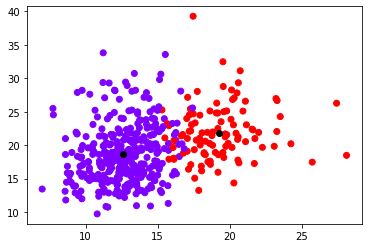

In [48]:
plt.scatter(iiiX_train.values[:,0],iiiX_train.values[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')

In [52]:
# # Compute the centers of the two clusters and find the closest 30 data points to each center
# ##To compare with the true labels of the training data, I will have the original data concatenated
combine = iiiX_train.copy(deep=True)
combine['Y_train'] = iiiY_train

# #make a copy of the combined df
dataX = combine.copy(deep=True)
# #find the 30 data points that are closest to the centroids
distance = kmeans.transform(iiiX_train)[:,0]
dataX['cluster'] = kmeans.labels_
dataX['distance'] = distance
closest30 = np.sort(distance)[:30]

twodf = dataX.iloc[:,-3:]

df0 = twodf[twodf['cluster'] == 0] 
df1 = twodf[twodf['cluster'] == 1]

df0=df0.sort_values(by=['distance'])
df1=df1.sort_values(by=['distance'])
closest0 = df0.head(30)
closest1 = df1.head(30)

# # Read the true labels of those 30 data points and take a majority poll within them
# compare = closest0['cluster'].join(closest0['Y_train'])
try:
    countc0 = closest0['cluster'].value_counts()[0]
except: 
    countc0 = 0

try:
    countc1 = closest0['cluster'].value_counts()[1]
except:
    countc1 = 0

try:
    county0 = closest0['Y_train'].value_counts()[0]
except:
    county0 = 0

try:
    county1 = closest0['Y_train'].value_counts()[1]
except:
    county1 = 0

try:
    countc10 = closest1['cluster'].value_counts()[0]
except:
    countc10 = 0

try:
    county10 = closest1['Y_train'].value_counts()[0]

except:
    county10 = 0

try:
    countc11 = closest1['cluster'].value_counts()[1]
except:
    countc11 = 0

try:
    county11 = closest1['Y_train'].value_counts()[1]
except:
    county11 = 0

if (countc0 + county0) > (county1 + countc1):
    majority0 = countc0
else:
    majority0 = county1

if (countc10 + county10) > (county11 + countc11):
    majority1 = countc10
else:
    majority1 = county11


    
# #combine the replaced labels to the rest

df0['cluster'].update(majority0)
df1['cluster'].update(majority1)
updf = pd.concat([df0,df1])

#assign new Ytrain
upY_train = updf['Y_train']


In [53]:
#Run K means
upkmeans = KMeans(n_clusters=2,n_init = 100, random_state=None)
upkmeans.fit(iiiX_train)
upY_pred = upkmeans.predict(iiiX_train)

# average accuracy, precision, recall, F 1 -score, and AUC
accuracy = accuracy_score(iiiY_train,upY_pred)
report['Accuracy'] = accuracy
cr = precision_recall_fscore_support(iiiY_train, upY_pred, average='weighted')
report['Classification_R'] = cr
fpr, tpr, thresholds = metrics.roc_curve(iiiY_train, upY_pred)
AUC = metrics.auc(fpr, tpr)
report['AUC'] = AUC
report['fpr'] = fpr
report['tpr'] = tpr

print ("Accuracy: ",report['Accuracy'])
print ("Precision: ", report["Classification_R"][0])
print ("Recall: ", report["Classification_R"][1])
print ("F1-Score: ", report["Classification_R"][2])
print ("AUC: ", report["AUC"])

Accuracy:  0.8546255506607929
Precision:  0.8795379889077427
Recall:  0.8546255506607929
F1-Score:  0.8449850244203334
AUC:  0.8059379217273954


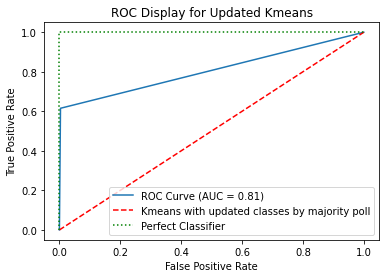

In [54]:
#Plot ROC
fpr, tpr, thresholds = metrics.roc_curve(iiiY_train, upY_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label='ROC Curve (AUC = %0.2f)'%(roc_auc))
plt.plot([0,1],[0,1], linestyle='--',color='red',label = 'Kmeans with updated classes by majority poll')
plt.plot([0,0,1],[0,1,1],linestyle=':',color = 'green', label='Perfect Classifier')
plt.title('ROC Display for Updated Kmeans')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [55]:
cm = confusion_matrix(iiiY_train, upY_pred)
print ("Confusion Matrix", "\n", cm)


Confusion Matrix 
 [[284   1]
 [ 65 104]]


In [56]:
#Monte-Carlo: 

iiiavg_acc = []
iiiavg_prc = []
iiiavg_rec = []
iiiavg_F = []
iiiavg_AUC = []

upavg_acc = []
upavg_prc = []
upavg_rec = []
upavg_F = []
upavg_AUC = []


#MC = 30
for mc in range (30):
    #Split test & training data -- "make sure to use 20% of both positive & negative classes as the test set"
    iiiX_train, iiiX_test, iiiY_train, iiiY_test = train_test_split(X,Y_new, test_size = 0.20, random_state=None, stratify = Y)
    kmeans = KMeans(n_clusters=2,n_init = 100, random_state=None)
    kmeans.fit(iiiX_train)
   
    # # Compute the centers of the two clusters and find the closest 30 data points to each center
    # ##To compare with the true labels of the training data, I will have the original data concatenated
    combine = iiiX_train.copy(deep=True)
    combine['Y_train'] = iiiY_train

    # #make a copy of the combined df
    dataX = combine.copy(deep=True)
    # #find the 30 data points that are closest to the centroids
    distance = kmeans.transform(iiiX_train)[:,0]
    dataX['cluster'] = kmeans.labels_
    dataX['distance'] = distance
    closest30 = np.sort(distance)[:30]

    twodf = dataX.iloc[:,-3:]

    df0 = twodf[twodf['cluster'] == 0] 
    df1 = twodf[twodf['cluster'] == 1]

    df0=df0.sort_values(by=['distance'])
    df1=df1.sort_values(by=['distance'])
    closest0 = df0.head(30)
    closest1 = df1.head(30)

    # Read the true labels of those 30 data points and take a majority poll within them
    try:
        countc0 = closest0['cluster'].value_counts()[0]
    except: 
        countc0 = 0

    try:
        countc1 = closest0['cluster'].value_counts()[1]
    except:
        countc1 = 0

    try:
        county0 = closest0['Y_train'].value_counts()[0]
    except:
        county0 = 0

    try:
        county1 = closest0['Y_train'].value_counts()[1]
    except:
        county1 = 0

    try:
        countc10 = closest1['cluster'].value_counts()[0]
    except:
        countc10 = 0

    try:
        county10 = closest1['Y_train'].value_counts()[0]

    except:
        county10 = 0

    try:
        countc11 = closest1['cluster'].value_counts()[1]
    except:
        countc11 = 0

    try:
        county11 = closest1['Y_train'].value_counts()[1]
    except:
        county11 = 0

    if (countc0 + county0) > (county1 + countc1):
        majority0 = countc0
    else:
        majority0 = county1

    if (countc10 + county10) > (county11 + countc11):
        majority1 = countc10
    else:
        majority1 = county11

    #combine the replaced labels to the rest
    #logic: replace the dataX cluster value to that of closest0 cluster value if they have the same distance value


    df0['cluster'].update(majority0)
    df1['cluster'].update(majority1)
    updf = pd.concat([df0,df1])

    #assign new Ytrain
    
    upY_train = updf['Y_train']

    #Run K means
    upkmeans = KMeans(n_clusters=2,n_init = 100, random_state=None)
    upkmeans.fit(iiiX_train)
    upkmeans.fit(iiiX_train)

    # #Fit L 1 -penalized SVM with the found optimal C
    upY_pred = upkmeans.predict(iiiX_train)

    # average accuracy, precision, recall, F 1 -score, and AUC
    report = {}
    
    accuracy = accuracy_score(iiiY_train,upY_pred)
    report['Accuracy'] = accuracy
    cr = precision_recall_fscore_support(iiiY_train, upY_pred, average='weighted')
    report['Classification_R'] = cr
    fpr, tpr, thresholds = metrics.roc_curve(iiiY_train, upY_pred)
    AUC = metrics.auc(fpr, tpr)
    report['AUC'] = AUC
    
    iiiavg_acc.append(report['Accuracy'])
    iiiavg_prc.append(report['Classification_R'][0])
    iiiavg_rec.append(report['Classification_R'][1])
    iiiavg_F.append(report['Classification_R'][2])
    iiiavg_AUC.append(report['AUC'])
    
    #Monte-Carlo For Test Data---------------

    # Classify test data based on their proximity to the centers of the clusters.
    
    upkmeans.fit(iiiX_test)
    upred = upkmeans.labels_
    
    # average accuracy, precision, recall, F 1 -score, and AUC
    accuracy = accuracy_score(iiiY_test,upred)
    report['Accuracy'] = accuracy
    cr = precision_recall_fscore_support(iiiY_test, upred, average='weighted')
    report['Classification_R'] = cr
    fpr, tpr, thresholds = metrics.roc_curve(iiiY_test, upred)
    AUC = metrics.auc(fpr, tpr)
    report['AUC'] = AUC
    report['fpr'] = fpr
    report['tpr'] = tpr


    upavg_acc.append(report['Accuracy'])
    upavg_prc.append(report['Classification_R'][0])
    upavg_rec.append(report['Classification_R'][1])
    upavg_F.append(report['Classification_R'][2])
    upavg_AUC.append(report['AUC'])
    
print ("Average Accuracy: ",mean(iiiavg_rec))
print ("Average Precision: ",mean(iiiavg_prc))
print ("Average Recall: ",mean(iiiavg_rec))
print ("Average F1-Score: ",mean(iiiavg_F))
print ("Average AUC: ",mean(iiiavg_AUC))

print("\n", "----------For Test Data-----------","\n")
print ("Average Accuracy: ",mean(upavg_rec))
print ("Average Precision: ",mean(upavg_prc))
print ("Average Recall: ",mean(upavg_rec))
print ("Average F1-Score: ",mean(upavg_F))
print ("Average AUC: ",mean(upavg_AUC))

Average Accuracy:  0.63928046989721
Average Precision:  0.6366637994193379
Average Recall:  0.63928046989721
Average F1-Score:  0.6176155902206096
Average AUC:  0.6188833523651337

 ----------For Test Data----------- 

Average Accuracy:  0.6616959064327486
Average Precision:  0.6627073865260319
Average Recall:  0.6616959064327486
Average F1-Score:  0.6370577320112344
Average AUC:  0.636276455026455


C. Classify test data based on their proximity to the centers of the clusters.
Report the average accuracy, precision, recall,
F
1
-score, and AUC over
M
runs, and ROC and the confusion matrix for one of the runs for the
test data.

Confusion Matrix 
 [[60 12]
 [34  8]]
Average Accuracy:  0.8070175438596491
Average Precision:  0.8521836506159014
Average Recall:  0.8070175438596491
Average F1-Score:  0.7855667150776281
Average AUC:  0.7380952380952381


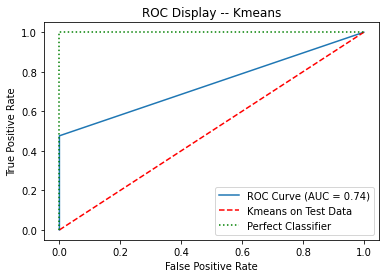

In [57]:
#Monte Carlo Practiced above. Runnint this to plot ROC and Confusion Matrix

# Classify test data based on their proximity to the centers of the clusters.
kmeans = KMeans(n_clusters=2,n_init = 100, random_state=None)
kmeans.fit(iiiX_test)
upred = kmeans.labels_

# average accuracy, precision, recall, F 1 -score, and AUC
accuracy = accuracy_score(iiiY_test,upred)
report['Accuracy'] = accuracy
cr = precision_recall_fscore_support(iiiY_test, upred, average='weighted')
report['Classification_R'] = cr
fpr, tpr, thresholds = metrics.roc_curve(iiiY_test, upred)
AUC = metrics.auc(fpr, tpr)
report['AUC'] = AUC
report['fpr'] = fpr
report['tpr'] = tpr

cm = confusion_matrix(Y_test, upred)
print ("Confusion Matrix", "\n", cm)

print("Average Accuracy: ",report['Accuracy'])
print("Average Precision: ", report['Classification_R'][0])
print("Average Recall: ", report['Classification_R'][1])
print("Average F1-Score: ", report['Classification_R'][2])
print("Average AUC: ", report['AUC'])

#Plot ROC
fpr, tpr, thresholds = metrics.roc_curve(iiiY_test, upred)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label='ROC Curve (AUC = %0.2f)'%(roc_auc))
plt.plot([0,1],[0,1], linestyle='--',color='red',label = 'Kmeans on Test Data')
plt.plot([0,0,1],[0,1,1],linestyle=':',color = 'green', label='Perfect Classifier')
plt.title('ROC Display -- Kmeans')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


Spectral Clustering

In [58]:
#Split test & training data -- "make sure to use 20% of both positive & negative classes as the test set"
spX_train, spX_test, spY_train, spY_test = train_test_split(X,Y_new, test_size = 0.20, random_state=None, stratify = Y)

scaler = StandardScaler()
spX_train = scaler.fit_transform(spX_train)
spX_test = scaler.fit_transform(spX_test)

# #normalize the data
spX_train = normalize(spX_train)
spX_test = normalize(spX_test)

spX_train = pd.DataFrame(spX_train)
spX_test = pd.DataFrame(spX_test)

spX_train.columns = ["radius_mean","texture_mean","perimeter_mean",
       "area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean",
       "symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se",
       "smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se",
       "fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst",
       "smoothness_worst","compactness_worst","concavity_worst","concave points_worst",
       "symmetry_worst","fractal_dimension_worst"]
spX_test.columns = ["radius_mean","texture_mean","perimeter_mean",
       "area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean",
       "symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se",
       "smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se",
       "fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst",
       "smoothness_worst","compactness_worst","concavity_worst","concave points_worst",
       "symmetry_worst","fractal_dimension_worst"]

In [59]:
Y_nm = spY_train.copy()
Y_nm = pd.DataFrame(Y_nm, columns = ['og_labels'])
totalspdf = pd.concat([spX_train,Y_nm],axis = 1)


In [60]:
spec_clust = SpectralClustering(n_clusters = 2, affinity = 'rbf', assign_labels = 'discretize', n_init = 100, random_state=None, gamma = 1)
spred = spec_clust.fit_predict(spX_train)
totalspdf['pred_labels'] = spred

In [61]:
# Compute the centers of the two clusters and find the closest 30 data points to each center
#label based on either 30 randomly selected data points instead.
#For ROC curves, you can vary the threshold of majority polling to obtain an ROC.


randomdf = totalspdf.sample(n=30)
minusdf = totalspdf.drop(randomdf.index)

# Read the true labels of those 30 data points and take a majority poll within them
zro = 0
wne = 0
ranys = randomdf[['og_labels','pred_labels']].to_numpy()
for i in ranys:
    if i[0] == 0:
        zro = zro + 1
    if i[0] == 1:
        wne = wne + 1
    if i[1] == 0:
        zro = zro + 1
    if i[1] == 1:
        wne = wne + 1
# print (zro,wne)
if zro > wne:
    maj = 0
    mino = 1
if zro < wne:
    maj = 1 
    mino = 0
# The majority poll becomes the label predicted by k-means
randomdf.replace({'pred_lables': mino}, maj)

uplabdf = pd.concat([randomdf,minusdf], axis = 0)

tempX_train = uplabdf.iloc[:,:-2]
tempY_pred = uplabdf.iloc[:,-1:]
tempY_train = uplabdf.iloc[:,-2:-1]



Confusion Matrix 
 [[259  26]
 [ 14 155]]
Accuracy:  0.9118942731277533
Precision:  0.9143356217856669
Recall:  0.9118942731277533
F1-Score:  0.9124572836097633
AUC:  0.9129658465690853


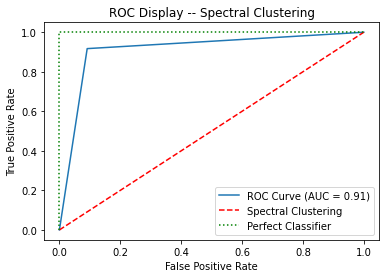

In [62]:
report = {}
# average accuracy, precision, recall, F 1 -score, and AUC
accuracy = accuracy_score(tempY_train,tempY_pred)
report['Accuracy'] = accuracy
cr = precision_recall_fscore_support(tempY_train, tempY_pred, average='weighted')
report['Classification_R'] = cr
fpr, tpr, thresholds = metrics.roc_curve(tempY_train, tempY_pred)
AUC = metrics.auc(fpr, tpr)
report['AUC'] = AUC

cm = confusion_matrix(tempY_train,tempY_pred)
print ("Confusion Matrix", "\n", cm)

print ("Accuracy: ",report['Accuracy'])
print ("Precision: ", report["Classification_R"][0])
print ("Recall: ", report["Classification_R"][1])
print ("F1-Score: ", report["Classification_R"][2])
print ("AUC: ", report["AUC"])

#Plot ROC
fpr, tpr, thresholds = metrics.roc_curve(tempY_train, tempY_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label='ROC Curve (AUC = %0.2f)'%(roc_auc))
plt.plot([0,1],[0,1], linestyle='--',color='red',label = 'Spectral Clustering')
plt.plot([0,0,1],[0,1,1],linestyle=':',color = 'green', label='Perfect Classifier')
plt.title('ROC Display -- Spectral Clustering')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [63]:
#Monte Carlo:

spavg_acc = []
spavg_prc = []
spavg_rec = []
spavg_F = []
spavg_AUC = []

tspavg_acc = []
tspavg_prc = []
tspavg_rec = []
tspavg_F = []
tspavg_AUC = []

#MC = 30
for mc in range (30):
    #Split test & training data -- "make sure to use 20% of both positive & negative classes as the test set"
    spX_train, spX_test, spY_train, spY_test = train_test_split(X,Y_new, test_size = 0.20, random_state=None, stratify = Y)


    scaler = StandardScaler()
    spX_train = scaler.fit_transform(spX_train)
    spX_test = scaler.fit_transform(spX_test)


    # #normalize the data
    spX_train = normalize(spX_train)
    spX_test = normalize(spX_test)


    spX_train = pd.DataFrame(spX_train)
    spX_test = pd.DataFrame(spX_test)


    spX_train.columns = ["radius_mean","texture_mean","perimeter_mean",
           "area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean",
           "symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se",
           "smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se",
           "fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst",
           "smoothness_worst","compactness_worst","concavity_worst","concave points_worst",
           "symmetry_worst","fractal_dimension_worst"]
    spX_test.columns = ["radius_mean","texture_mean","perimeter_mean",
           "area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean",
           "symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se",
           "smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se",
           "fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst",
           "smoothness_worst","compactness_worst","concavity_worst","concave points_worst",
           "symmetry_worst","fractal_dimension_worst"]
    
    Y_nm = spY_train.copy()
    Y_nm = pd.DataFrame(Y_nm, columns = ['og_labels'])
    totalspdf = pd.concat([spX_train,Y_nm],axis = 1)

    spec_clust = SpectralClustering(n_clusters = 2, affinity = 'rbf', assign_labels = 'discretize', n_init = 100, random_state=None, gamma = 1)
    spred = spec_clust.fit_predict(spX_train)
    totalspdf['pred_labels'] = spred
    
    # Compute the centers of the two clusters and find the closest 30 data points to each center
    #label based on either 30 randomly selected data points instead.
    #For ROC curves, you can vary the threshold of majority polling to obtain an ROC.

    # totalspdf
    randomdf = totalspdf.sample(n=30)
    minusdf = totalspdf.drop(randomdf.index)

    # Read the true labels of those 30 data points and take a majority poll within them
    zro = 0
    wne = 0
    ranys = randomdf[['og_labels','pred_labels']].to_numpy()
    for i in ranys:
        if i[0] == 0:
            zro = zro + 1
        if i[0] == 1:
            wne = wne + 1
        if i[1] == 0:
            zro = zro + 1
        if i[1] == 1:
            wne = wne + 1
    # print (zro,wne)
    if zro > wne:
        maj = 0
        mino = 1
    if zro < wne:
        maj = 1 
        mino = 0
        
    # The majority poll becomes the label predicted by k-means
    randomdf.replace({'pred_lables': mino}, maj)

    uplabdf = pd.concat([randomdf,minusdf], axis = 0)

    tempX_train = uplabdf.iloc[:,:-2]
    tempY_pred = uplabdf.iloc[:,-1:]
    tempY_train = uplabdf.iloc[:,-2:-1]

    report = {}
    # average accuracy, precision, recall, F 1 -score, and AUC
    accuracy = accuracy_score(tempY_train,tempY_pred)
    report['Accuracy'] = accuracy
    cr = precision_recall_fscore_support(tempY_train, tempY_pred, average='weighted')
    report['Classification_R'] = cr
    fpr, tpr, thresholds = metrics.roc_curve(tempY_train, tempY_pred)
    AUC = metrics.auc(fpr, tpr)
    report['AUC'] = AUC

    spavg_acc.append(report['Accuracy'])
    spavg_prc.append(report['Classification_R'][0])
    spavg_rec.append(report['Classification_R'][1])
    spavg_F.append(report['Classification_R'][2])
    spavg_AUC.append(report['AUC'])
    
    #Monte-Carlo For Test Data---------------

    spec_clust = SpectralClustering(n_clusters = 2, affinity = 'rbf', assign_labels = 'discretize', n_init = 100, random_state=None, gamma = 1)
    tempY_pred = spec_clust.fit_predict(spX_test)
    report = {}
    # average accuracy, precision, recall, F 1 -score, and AUC
    accuracy = accuracy_score(spY_test,tempY_pred)
    report['Accuracy'] = accuracy
    cr = precision_recall_fscore_support(spY_test, tempY_pred, average='weighted')
    report['Classification_R'] = cr
    fpr, tpr, thresholds = metrics.roc_curve(spY_test, tempY_pred)
    AUC = metrics.auc(fpr, tpr)
    report['AUC'] = AUC
    
    tspavg_acc.append(report['Accuracy'])
    tspavg_prc.append(report['Classification_R'][0])
    tspavg_rec.append(report['Classification_R'][1])
    tspavg_F.append(report['Classification_R'][2])
    tspavg_AUC.append(report['AUC'])


print ("Average Accuracy: ",mean(spavg_acc))
print ("Average Precision: ",mean(spavg_prc))
print ("Average Recall: ",mean(spavg_rec))
print ("Average F1-Score: ",mean(spavg_F))
print ("Average AUC: ",mean(spavg_AUC))

print("\n", "----------For Test Data-----------","\n")

print ("Average Accuracy: ",mean(tspavg_acc))
print ("Average Precision: ",mean(tspavg_prc))
print ("Average Recall: ",mean(tspavg_rec))
print ("Average F1-Score: ",mean(tspavg_F))
print ("Average AUC: ",mean(tspavg_AUC))

Average Accuracy:  0.5560205580029368
Average Precision:  0.565067807823629
Average Recall:  0.5560205580029368
Average F1-Score:  0.5582184993997099
Average AUC:  0.5555780476833109

 ----------For Test Data----------- 

Average Accuracy:  0.7008771929824561
Average Precision:  0.7086883401614311
Average Recall:  0.7008771929824561
Average F1-Score:  0.7022771602328131
Average AUC:  0.6985449735449736


An interesting finding: 
>I found it interesting that the Average scores wasn't as high as ran alone, despite the same coding. 

Maybe...The result of spectral Clustering is very inconsistent.

In [64]:
zipp=zip(spavg_acc,spavg_prc,spavg_rec,spavg_F,spavg_AUC)
zipped = pd.DataFrame(zipp)
zipped.columns = ['spavg_acc','spavg_prc','spavg_rec','spavg_F','spavg_AUC']
zipped

,spavg_acc,spavg_prc,spavg_rec,spavg_F,spavg_AUC
0,0.909692,0.911327,0.909692,0.910138,0.908803
1,0.905286,0.906961,0.905286,0.905755,0.904090
2,0.083700,0.105672,0.083700,0.090055,0.081117
3,0.083700,0.101730,0.083700,0.087543,0.084730
4,0.903084,0.906264,0.903084,0.903791,0.904744
5,0.920705,0.922004,0.920705,0.921057,0.919983
6,0.929515,0.930743,0.929515,0.929829,0.929409
7,0.920705,0.921580,0.920705,0.920975,0.918779
8,0.072687,0.088743,0.072687,0.076121,0.073549
9,0.925110,0.926374,0.925110,0.925443,0.924696


C. Classify test data based on their proximity to the centers of the clusters. Report the average accuracy, precision, recall, F 1 -score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data.

Confusion Matrix 
 [[68  4]
 [ 5 37]]
Accuracy:  0.9210526315789473
Precision:  0.9207976506585542
Recall:  0.9210526315789473
F1-Score:  0.9208492773270942
AUC:  0.9126984126984126


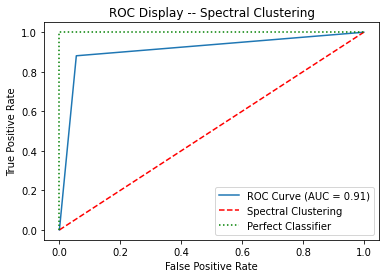

In [67]:
#Monte Carlo Practiced above. Runnint this to plot ROC and Confusion Matrix

spec_clust = SpectralClustering(n_clusters = 2, affinity = 'rbf', assign_labels = 'discretize', n_init = 100, random_state=None, gamma = 1)
tempY_pred = spec_clust.fit_predict(spX_test)
report = {}
# average accuracy, precision, recall, F 1 -score, and AUC
accuracy = accuracy_score(spY_test,tempY_pred)
report['Accuracy'] = accuracy
cr = precision_recall_fscore_support(spY_test, tempY_pred, average='weighted')
report['Classification_R'] = cr
fpr, tpr, thresholds = metrics.roc_curve(spY_test, tempY_pred)
AUC = metrics.auc(fpr, tpr)
report['AUC'] = AUC

cm = confusion_matrix(spY_test,tempY_pred)
print ("Confusion Matrix", "\n", cm)

print ("Accuracy: ",report['Accuracy'])
print ("Precision: ", report["Classification_R"][0])
print ("Recall: ", report["Classification_R"][1])
print ("F1-Score: ", report["Classification_R"][2])
print ("AUC: ", report["AUC"])

#Plot ROC
fpr, tpr, thresholds = metrics.roc_curve(spY_test, tempY_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label='ROC Curve (AUC = %0.2f)'%(roc_auc))
plt.plot([0,1],[0,1], linestyle='--',color='red',label = 'Spectral Clustering')
plt.plot([0,0,1],[0,1,1],linestyle=':',color = 'green', label='Perfect Classifier')
plt.title('ROC Display -- Spectral Clustering')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

Compare the results:
> According to results that I obtained, the supervised learning on the full data had the highest performance with 0.93 accuracy. Semi-supervised learning was not as well performing as supervised, but still had a high accuracy of 0.81, and so did unsupervised learning. 

> One thing that was interesting is that I expected semi-supervised learning to perform better, result a higher accuracy, than the unsupervised learning as it is learning from a label-existing data. Yet, for this data and the model I used, unsupervised learning had a higher accuracy. 

>Lastly, I mentioned this above, I found the result of the spectral clustering interesting. At first I was surprised by the low accuracy rate. Yet, I found that each run (out of 50 monte carlo), the results were extremely inconsistent. Half the trains were performing really well with over .90 accuracy score, when the other half of the trains had almost a zero, therefore pulling the average accuracy score to .60.